In [1]:
from stellargraph.data import EdgeSplitter
import numpy as np
from sklearn.model_selection import train_test_split
import multiprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

import stellargraph as sg
import matplotlib.pyplot as plt
import networkx as nx

## Constansok

In [2]:
# ['0', '107']
edge_path = 'facebook/0.edges' # 0.edges

In [3]:
# Map Node ids to be continious
def create_mapping(path):
    with open(path, 'rt') as file:
        text = file.read()

    # Read File
    connections = []
    from_list = []
    to_list = []
    for row in text.split('\n')[:-1]:
        a, b = [int(x) for x in row.split(' ')]
        connections.append((a, b))

        from_list.append(a)
        to_list.append(b)


    id_mapper = {}
    reverse_id_mapper = {}
    counter = 0
    for elem in from_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    for elem in to_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    scaled_connections = []
    for first, second in connections:
        first_scaled = reverse_id_mapper[first]
        second_scaled = reverse_id_mapper[second]

        scaled_connections.append((first_scaled, second_scaled))

    return id_mapper, reverse_id_mapper, scaled_connections

def read_graph(path, map = True):
    id_mapper_ = None
    reverse_id_mapper_ = None

    if map:
        id_mapper_, reverse_id_mapper_, edges = create_mapping(path)
        G_ = nx.Graph()
        G_.add_edges_from(edges)
    else:
        G_ = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

    G_ = sg.StellarGraph.from_networkx(G_)

    return G_, id_mapper_, reverse_id_mapper_

def print_graph_info(graph):
    print(graph.info())

In [4]:
# Graph Info
G, id_mapper, reverse_id_mapper = read_graph(edge_path, map =True)
print_graph_info(G)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2519

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2519]
        Weights: all 1 (default)
        Features: none


## Start

In [5]:
edge_splitter_test = EdgeSplitter(G)

In [6]:
# Here it takes edges from the edge_splitter test, these are the examples_test,
# Then it takes negative edges and adds them to the examples_test concatenated,
# the labels_test shows whether the edge exists or negative
# the graph_test is the graph with the remaining edges
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")

** Sampled 251 positive and 251 negative edges. **


In [8]:
print_graph_info(graph_test)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2268

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2268]
        Weights: all 1 (default)
        Features: none


In [9]:
edge_splitter_train = EdgeSplitter(g=graph_test, g_master=G)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.1, method="global")

(examples_train, examples_model_selection, labels_train, labels_model_selection,)\
                                        = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

** Sampled 226 positive and 226 negative edges. **


In [10]:
print_graph_info(graph_train)

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2042

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2042]
        Weights: all 1 (default)
        Features: none


In [11]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,339,Train Graph,Test Graph,Train the Link Classifier
Model Selection,113,Train Graph,Test Graph,Select the best Link Classifier model
Test set,502,Test Graph,Full Graph,Evaluate the best Link Classifier


In [12]:
used_params = {
    'p': 1.0,
    'q': 0.6,
    'dimensions': 128,
    'num_walks': 100,
    'walk_length': 30,
    'window_size': 13,
    'num_iter': 5,
    'workers': multiprocessing.cpu_count()
}

In [14]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=used_params['num_walks'], length=used_params['walk_length'], p=used_params['p'], q=used_params['q'])
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=used_params['dimensions'],
        window=used_params['window_size'],
        min_count=0,
        sg=1,
        workers=used_params['workers'],
        epochs=used_params['num_iter'],
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [15]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 33300


In [16]:
# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. training classifier
def train_link_prediction_model(
        link_examples, link_labels, get_embedding, binary_operator
):
    # Ezt akár lehet módosítani is más algoritmussal
    clf = link_prediction_classifier()

    # Itt távolságot számol a start és end pont embeddingje között
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    # Majd arra fitteli a modelt
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=4000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
        clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [17]:
def operator_hadamard(u, v):
    return u * v

def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [18]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l1'


,ROC AUC score
name,
operator_hadamard,0.849216
operator_l1,0.945141
operator_l2,0.942633
operator_avg,0.747022


In [19]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 33300


In [20]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l1': 0.9418580657449881


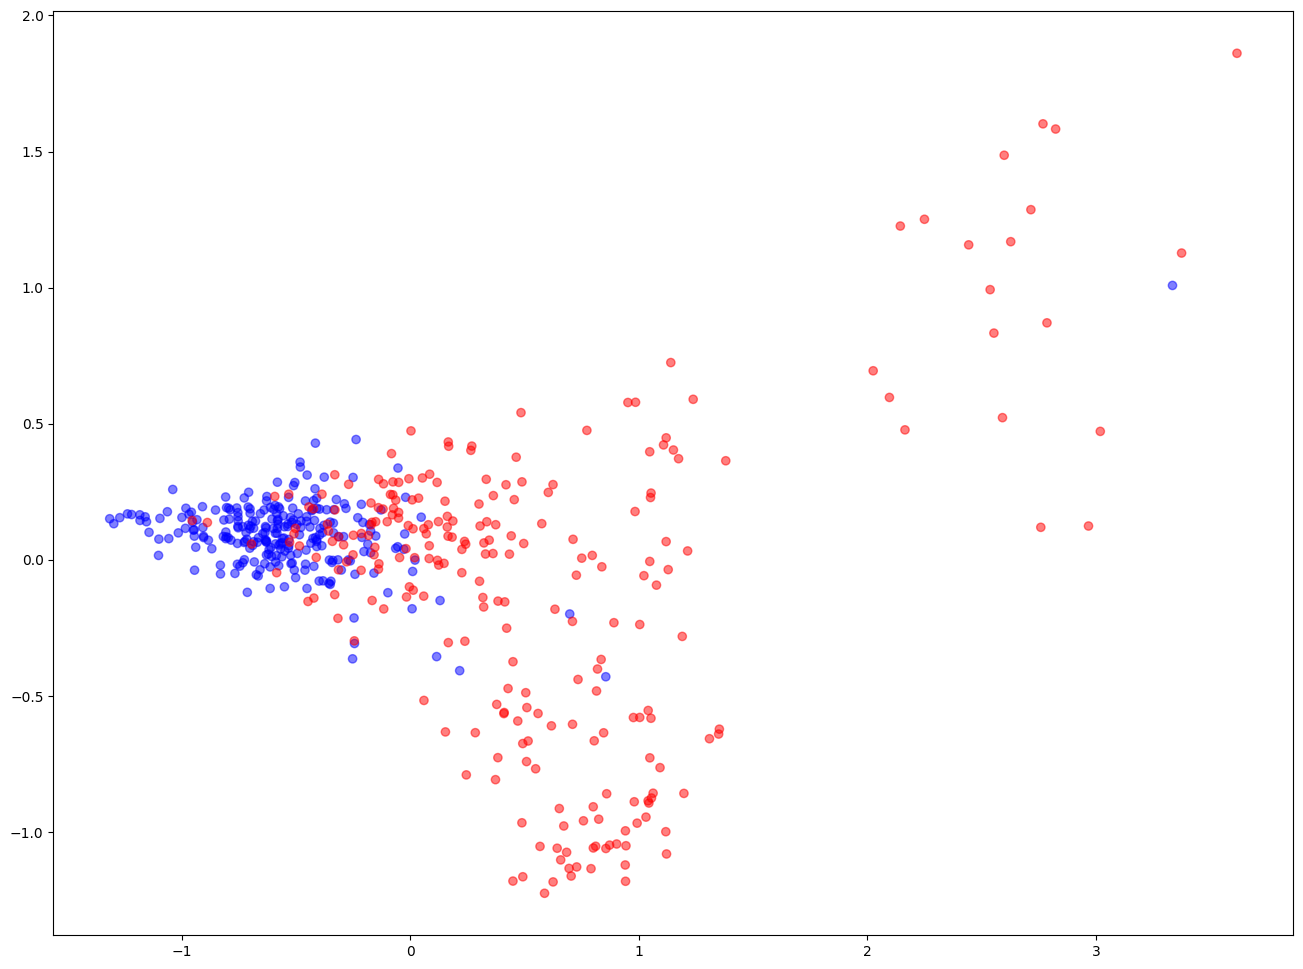

In [21]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
    )